# Viele Dateien

**Inhalt:** Massenverarbeitung von gescrapten Zeitreihen

**Nötige Skills:** Daten explorieren, Time+Date Basics

**Lernziele:**
- Pandas in Kombination mit Scraping
- Öffnen und zusammenfügen von vielen Dateien (Glob)
- Umstrukturierung von Dataframes (Pivot)
- Plotting Level 4 (Small Multiples)

## Das Beispiel

Wir interessieren uns in diesem Notebook für Krypto-Coins.

Die Webseite https://coinmarketcap.com/ führt Marktdaten zu den hundert wichtigsten Coins auf.

Mit einem einfachen Scraper werden wir diese Daten beschaffen und rudimentär analysieren.

Der Pfad zum Projektordner heisst `dataprojects/Krypto/`

## Vorbereitung

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import re

In [5]:
import glob

In [6]:
%matplotlib inline

## Scraper

In [7]:
path = 'dataprojects/Krypto/'

### Liste von allen Kryptowährungen

Zuerst kucken wir auf der Seite, welches die 100 grössten Kryptowährungen sind, und laden uns Namen und Links derselbigen.

In [8]:
base_url = 'https://coinmarketcap.com/'

In [9]:
response = requests.get(base_url)
doc = BeautifulSoup(response.text, "html.parser")

In [10]:
currencies = doc.find_all('a', class_='currency-name-container link-secondary')

In [11]:
currencies[0]

<a class="currency-name-container link-secondary" href="/currencies/bitcoin/">Bitcoin</a>

In [ ]:
len(currencies)

In [ ]:
currency_list = []

In [ ]:
for currency in currencies:
    this_currency = {}
    this_currency['name'] = currency.text
    this_currency['link'] = currency['href']
    currency_list.append(this_currency)

In [ ]:
df_currencies = pd.DataFrame(currency_list)

In [ ]:
df_currencies.head(2)

In [ ]:
df_currencies['link'] = df_currencies['link'].str.extract('/currencies/(.+)/')

In [ ]:
df_currencies.head(2)

In [ ]:
df_currencies.to_csv(path + 'currencies.csv', index=False)

### Daten von den einzelnen Währungen

Zuerst testen wir mit einer Probewährung aus, wie wir an die Informationen kommen.

In [ ]:
base_url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20171015&end=20181015'

In [ ]:
response = requests.get(base_url)
doc = BeautifulSoup(response.text, "html.parser")

In [ ]:
days = doc.find_all('tr', class_='text-right')

In [ ]:
days_list = []

In [ ]:
cells = days[0].find_all('td')

In [ ]:
cells

In [ ]:
this_day = {}

In [ ]:
this_day['date'] = cells[0].text
this_day['open'] = cells[1].text
this_day['high'] = cells[2].text
this_day['low'] = cells[3].text
this_day['close'] = cells[4].text
this_day['volume'] = cells[5].text
this_day['marketcap'] = cells[6].text

In [ ]:
this_day

In [ ]:
for day in days:
    this_day = {}
    cells = day.find_all('td')
    this_day['date'] = cells[0].text
    this_day['open'] = cells[1].text
    this_day['high'] = cells[2].text
    this_day['low'] = cells[3].text
    this_day['close'] = cells[4].text
    this_day['volume'] = cells[5].text
    this_day['marketcap'] = cells[6].text
    days_list.append(this_day)

In [ ]:
df = pd.DataFrame(days_list)

In [ ]:
df.head(2)

Nun wenden wir den Scraper auf alle Währungen an

In [ ]:
df_currencies = pd.read_csv(path + 'currencies.csv')

In [ ]:
df_currencies.head(2)

In [ ]:
len(df_currencies)

In [ ]:
currencies = df_currencies.to_dict(orient='records')

In [ ]:
url_start = 'https://coinmarketcap.com/currencies/'
url_end = '/historical-data/?start=20171015&end=20181015'

In [ ]:
for currency in currencies:
    print ('working on: ' + currency['name'])
    
    url = url_start + currency['link'] + url_end
    response = requests.get(url)
    doc = BeautifulSoup(response.text, "html.parser")
    
    days = doc.find_all('tr', class_='text-right')
    days_list = []
    
    this_day = {}
    for day in days:
        this_day = {}
        cells = day.find_all('td')
        this_day['date'] = cells[0].text
        this_day['open'] = cells[1].text
        this_day['high'] = cells[2].text
        this_day['low'] = cells[3].text
        this_day['close'] = cells[4].text
        this_day['volume'] = cells[5].text
        this_day['marketcap'] = cells[6].text
        days_list.append(this_day)
        
    df = pd.DataFrame(days_list)
    filename = currency['name'] + '.csv'
    df.to_csv(path + 'data/' + filename, index=False)
    
print('Done')

Am Ende haben wir eine Liste von Dateien: Zu jeder Kryptowährung existiert eine Tabelle mit den Marktdaten über den definierten Zeitraum.

Die Daten sind im Unterordner `data/` abgelegt.

## Daten analysieren

### Einlesen

Wir starten damit, dass wir das Verzeichnis durchsuchen, in dem alle Kryptowährungs-Daten abgelegt sind.

Dazu benutzen wir `glob`, ein praktisches Tool aus der Standard Library: https://docs.python.org/3/library/glob.html

In [12]:
filenames = glob.glob(path + 'data/*.csv') # wir machen eine Liste mit den Filenames 

In [13]:
len(filenames)

100

In [14]:
filenames[0:2]

['dataprojects/Krypto/data/Crypto.com.csv',
 'dataprojects/Krypto/data/IOTA.csv']

Mit Glob haben wir nun eine Liste mit den Dateinamen erstellt.

Nun lesen wir jede einzelne Datei aus der Liste ein.

So, dass wir als Ergebnis eine Liste von Dataframes erhalten.

In [16]:
dfs = []

In [17]:
dfs = [pd.read_csv(filename) for filename in filenames] # Listcomprehension

In [18]:
dfs[0].head(2)

,close,date,high,low,marketcap,open,volume
0,4.17,"Oct 14, 2018",4.29,4.14,"67,182,201",4.25,"669,732"
1,4.26,"Oct 13, 2018",4.27,4.12,"65,179,873",4.13,"607,244"


Die einzelnen Dataframes in der Liste enthalten die Marktdaten. Doch sie enthalten selbst keine Information darüber, zu welcher Kryptowährung die Daten gehören. Wir führen zu dem Zweck in jedes Dataframe noch eine zusätzliche Spalte hinzu mit dem Namen der Währung. 

In [20]:
for df, filename in zip(dfs, filenames): #zip ==> führt den code für die in Klammern aufgefüheten df gleichz. aus
    df['currency'] = filename
    df['currency'] = df['currency'].str.extract('/data/(.+).csv')

In [21]:
dfs[0].head(2)

,close,date,high,low,marketcap,open,volume,currency
0,4.17,"Oct 14, 2018",4.29,4.14,"67,182,201",4.25,"669,732",Crypto.com
1,4.26,"Oct 13, 2018",4.27,4.12,"65,179,873",4.13,"607,244",Crypto.com


Nun fügen wir alle Dataframes zu einem einzigen, sehr langen Dataframe zusammen.

Dazu benutzen wir die Funktion `pd.concat()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html

In [22]:
df_all = pd.concat(dfs, ignore_index=True) #ignore_index=True ==> die alte Indexierung soll überschrieben werden.
#concat führt listen untereinaner zusammen

In [23]:
df_all.shape

(32863, 8)

In [24]:
df_all.head(2)

,close,date,high,low,marketcap,open,volume,currency
0,4.17,"Oct 14, 2018",4.29,4.14,"67,182,201",4.25,"669,732",Crypto.com
1,4.26,"Oct 13, 2018",4.27,4.12,"65,179,873",4.13,"607,244",Crypto.com


In [26]:
df_all.tail(2)

,close,date,high,low,marketcap,open,volume,currency
32861,0.069312,"Oct 16, 2017",0.074696,0.066433,"67,048,172",0.067115,"5,472,330",Nxt
32862,0.067413,"Oct 15, 2017",0.073371,0.064375,"67,901,304",0.067969,"3,431,370",Nxt


In [27]:
df_all.dtypes

close        float64
date          object
high         float64
low          float64
marketcap     object
open         float64
volume        object
currency      object
dtype: object

Wir haben nun ein ellenlanges Dataframe. What next?

### Arrangieren

Das hängt davon ab, was wir mit den Daten genau tun wollen.

Eine Option wäre: die verschiedenen Währungen miteinander zu vergleichen. Und zwar anhand der Schlusskurse.

Dazu müssen wir das Dataframe leicht umstellen, mit `pivot()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html

In [28]:
df_pivoted = df_all.pivot(index='date', columns='currency', values='close')

In [29]:
df_pivoted.shape

(365, 100)

In [30]:
df_pivoted.head(2)

currency,0x,Aeternity,Aion,Ardor,Ark,Augur,Aurora,Bancor,Basic Attenti...,Binance Coin,...,VeChain,Verge,WAX,Waltonchain,Wanchain,Waves,XRP,Zcash,Zilliqa,aelf
date,,,,,,,,,,,,,,,,,,,,,
"Apr 01, 2018",0.504651,1.47,1.93,0.213824,1.90,24.35,NaN,2.18,0.186136,11.07,...,NaN,0.043729,0.136101,9.44,3.08,3.49,0.485081,182.48,0.043248,0.520976
"Apr 02, 2018",0.531577,1.47,2.09,0.237127,2.09,25.59,NaN,2.20,0.199357,12.62,...,NaN,0.047822,0.142425,10.03,3.19,3.76,0.500688,193.89,0.044648,0.522643


In [31]:
df_pivoted.tail(2)

currency,0x,Aeternity,Aion,Ardor,Ark,Augur,Aurora,Bancor,Basic Attenti...,Binance Coin,...,VeChain,Verge,WAX,Waltonchain,Wanchain,Waves,XRP,Zcash,Zilliqa,aelf
date,,,,,,,,,,,,,,,,,,,,,
"Sep 29, 2018",0.653782,1.09,0.419475,0.123675,0.721113,13.51,0.021923,1.51,0.168362,10.00,...,0.013052,0.014766,0.068678,2.91,0.929787,2.22,0.571228,133.51,0.035294,0.335308
"Sep 30, 2018",0.652157,1.07,0.416852,0.120550,0.713016,13.42,0.021151,1.51,0.171174,10.02,...,0.012891,0.015184,0.068069,2.98,0.974530,2.20,0.581572,131.99,0.035640,0.335698


In [32]:
df_pivoted.rename_axis(None, inplace=True)

Nun verfügen wir über einen Index, bei dem eine Zeile jeweils einem einzigartigen Zeitpunkt entspricht.

Um damit zu arbeiten, verwandeln wir den Text in der Indexspalte in ein echtes Datum des Typs datetime.

In [33]:
df_pivoted.index = pd.to_datetime(df_pivoted.index, format="%b %d, %Y")

In [34]:
df_pivoted.sort_index(inplace=True)

In [35]:
df_pivoted.head(2)

currency,0x,Aeternity,Aion,Ardor,Ark,Augur,Aurora,Bancor,Basic Attenti...,Binance Coin,...,VeChain,Verge,WAX,Waltonchain,Wanchain,Waves,XRP,Zcash,Zilliqa,aelf
2017-10-15,0.197635,0.315538,NaN,0.261466,2.86,18.66,NaN,2.34,0.158654,1.56,...,NaN,0.005463,NaN,5.96,NaN,3.80,0.263983,232.63,NaN,NaN
2017-10-16,0.200841,0.356765,NaN,0.251497,2.78,19.09,NaN,2.33,0.176811,1.44,...,NaN,0.005153,NaN,6.24,NaN,4.02,0.256232,233.01,NaN,NaN


Wir haben nun ein sauber formatiertes Dataframe. Mit hundert Spalten, die für jede Kryptowährung, sofern sie zum betreffenden Zeitpunkt existierte, einen Handelskurs enthält.

Die nächste Frage ist: Wie vergleichen wir diese Kurse? Was sagt es aus, wenn eine Währung an einem bestimmten Tag zu 0,1976 USD gehandelt wurde und eine andere zu 18,66 USD?

### Vergleichbarkeit herstellen

Diverse Dinge würden sich hier anbieten:
- zB `pct_change()` um die Veränderungen in den Kursen zu analysieren
- oder eine indexierte Zeitreihe, die an einem bestimmten Tag bei 100 beginnt

Wir wählen die zweite Variante. Und speichern dazu die erste Zeile separat ab.

In [37]:
row_0 = df_pivoted.iloc[0]
row_0

currency
0x                     0.197635
Aeternity              0.315538
Aion                        NaN
Ardor                  0.261466
Ark                    2.860000
Augur                 18.660000
Aurora                      NaN
Bancor                 2.340000
Basic Attenti...       0.158654
Binance Coin           1.560000
BitShares              0.050607
Bitcoin             5678.190000
Bitcoin Cash         314.950000
Bitcoin Diamond             NaN
Bitcoin Gold                NaN
Bytecoin               0.001410
Bytom                  0.097466
Cardano                0.030049
Chainlink              0.413516
Crypto.com             7.510000
Cryptonex              2.850000
CyberMiles                  NaN
Dai                         NaN
Dash                 309.510000
Decentraland           0.013820
Decred                27.750000
Dentacoin              0.000114
DigiByte               0.009220
Digitex Futures             NaN
DigixDAO              65.560000
                       ...     

Dann teilen wir jede einzelne Zeile im Dataframe durch die erste Zeile. Und speichern als neues DF ab.

In [38]:
df_pivoted_100 = df_pivoted.apply(lambda row: row / row_0 * 100, axis=1)

Das neue Dataframe ist nun indexiert auf 100. Alle Währungen starten am gleichen Punkt...

In [39]:
df_pivoted_100.head(5)

currency,0x,Aeternity,Aion,Ardor,Ark,Augur,Aurora,Bancor,Basic Attenti...,Binance Coin,...,VeChain,Verge,WAX,Waltonchain,Wanchain,Waves,XRP,Zcash,Zilliqa,aelf
2017-10-15,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,...,NaN,100.000000,NaN,100.000000,NaN,100.000000,100.000000,100.000000,NaN,NaN
2017-10-16,101.622182,113.065621,NaN,96.187267,97.202797,102.304394,NaN,99.572650,111.444401,92.307692,...,NaN,94.325462,NaN,104.697987,NaN,105.789474,97.063826,100.163350,NaN,NaN
2017-10-17,111.939687,122.187185,NaN,93.783895,98.251748,100.214362,NaN,93.589744,104.254541,89.102564,...,NaN,89.785832,NaN,102.348993,NaN,103.157895,87.908691,99.419679,NaN,NaN
2017-10-18,111.004630,103.650907,NaN,87.765140,98.951049,98.285102,NaN,91.452991,102.385064,85.256410,...,NaN,92.037342,NaN,114.765101,NaN,106.315789,82.778058,98.568542,NaN,NaN
2017-10-19,114.185240,102.664021,NaN,84.256844,99.300699,97.266881,NaN,89.743590,96.886306,82.051282,...,NaN,89.785832,NaN,119.127517,NaN,102.368421,81.501460,98.899540,NaN,NaN


In [40]:
df_pivoted_100.tail(1)

currency,0x,Aeternity,Aion,Ardor,Ark,Augur,Aurora,Bancor,Basic Attenti...,Binance Coin,...,VeChain,Verge,WAX,Waltonchain,Wanchain,Waves,XRP,Zcash,Zilliqa,aelf
2018-10-14,359.33362,361.287705,NaN,43.021272,24.397692,64.576635,NaN,54.273504,108.630731,608.974359,...,NaN,255.280981,NaN,45.637584,NaN,49.736842,152.769686,46.657783,NaN,NaN


... und enden an einem bestimmten Punkt. Anhand dieses Punktes können wir die relative Entwicklung ablesen.

In [41]:
s_last = df_pivoted_100.iloc[-1]

Welche zehn Kryptowährungen am meisten Wert zugelegt haben...

In [42]:
s_last.sort_values(ascending=False).head(10)

currency
Nano            1294.947558
Stellar         1110.404227
TRON            1033.333333
EOS              903.982067
Binance Coin     608.974359
Decentraland     489.804631
Dogecoin         466.365280
Aeternity        361.287705
0x               359.333620
ReddCoin         274.978051
Name: 2018-10-14 00:00:00, dtype: float64

... und welche am meisten Wert verloren haben.

In [43]:
s_last.sort_values(ascending=False, na_position='first').tail(10)

currency
NEM              44.500724
Ardor            43.021272
OmiseGO          37.641154
Kyber Network    33.483571
Qtum             33.141762
TenX             29.460984
MonaCoin         27.751196
PIVX             27.272727
Ark              24.397692
HyperCash        15.450644
Name: 2018-10-14 00:00:00, dtype: float64

Und so sieht die Performance aller Währungen aus:

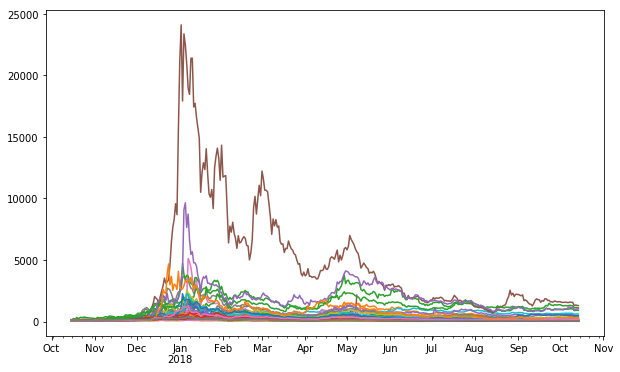

In [44]:
df_pivoted_100.plot(figsize=(10,6), legend=False)

Wow, das sind ziemlich viele Linien!

# Plotting Level 4

Wie wir diesen Chart etwas auseinandernehmen können, lernen wir hier.

Eine Gelegenheit, zu sehen, wie man die matplotlib-Funktionen direkt benutzen kann.

In [45]:
import matplotlib.pyplot as plt

In [46]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

Und eine neue Art kennenlernen, wie man einen Plot erstellt.

### Ein Plot

Starten wir zuerst mal mit einem Plots: Bitcoin.

Wir müssen uns dazu zuerst zwei Dinge basteln:
1. Eine "figure", also eine Abbildung
1. Einen "subplot", also der Plot selbst

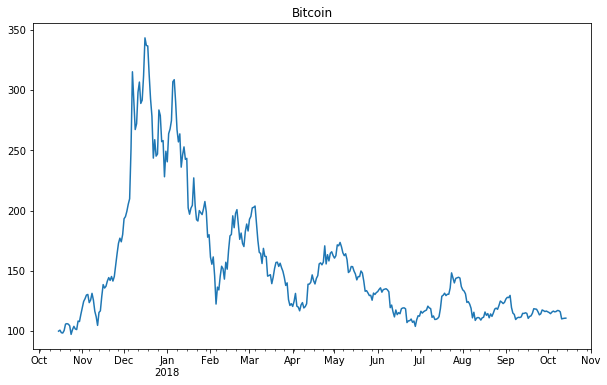

In [47]:
# Wir erstellen beide Dinge in einem Atemzug
fig, ax = plt.subplots(figsize=(10,6))

# Und füllen den Plot jetzt mit Inhalt:
df_pivoted_100['Bitcoin'].plot(title="Bitcoin", ax=ax)

### Zwei Plots

Als nächstes Plotten wir zwei Währungen auf derselben Figure: Bitcoin und Ethereum.

Wir müssen uns dazu erneut zwei Dinge basteln:
1. Eine "figure", also eine Abbildung
1. Diverse "subplots" für die jeweiligen Währungen

Dazu formatieren wir jetzt die x-Achse etwas speziell.

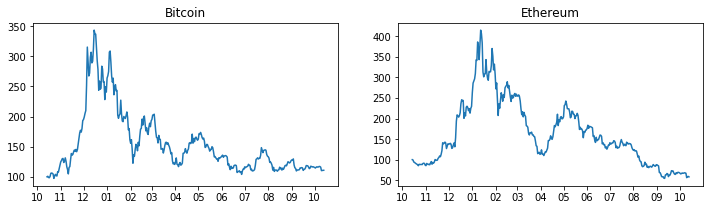

In [48]:
# Zuerst kreieren wir nur die Figure
fig = plt.figure(figsize=(12,3))

# Danach die einzelnen Subplots
ax1 = fig.add_subplot(1, 2, 1) # total 1 Zeile, total 2 Spalten, Subplot Nr. 1
ax2 = fig.add_subplot(1, 2, 2) # total 1 Zeile, total 2 Spalten, Subplot Nr. 2

# Und schliesslich füllen wir die Subplots mit Inhalt
df_pivoted_100['Bitcoin'].plot(title="Bitcoin", ax=ax1)
df_pivoted_100['Ethereum'].plot(title="Ethereum", ax=ax2)

# Hier formatieren wir die x-Achse für Plot 1
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Hier formatieren wir die x-Achse für Plot 2
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax2.xaxis.set_minor_locator(ticker.NullLocator())

Einige Angaben dazu, wie man Zeitachsen formatieren kann, gibt es hier:
- TickLocators: https://matplotlib.org/examples/ticks_and_spines/tick-locators.html
- TickFormatters: https://matplotlib.org/gallery/ticks_and_spines/tick-formatters.html

### Sehr viele Plots

Nun plotten wir sämtliche Währungen auf einmal. Wie viele sind es?

In [49]:
anzahl_charts = s_last.notnull().sum()
anzahl_charts

66

Wir sortieren unsere Liste der Währungen etwas:

In [50]:
sortierte_waehrungen = s_last[s_last.notnull()].sort_values(ascending=False)
sortierte_waehrungen.head(2)

currency
Nano       1294.947558
Stellar    1110.404227
Name: 2018-10-14 00:00:00, dtype: float64

Und wiederholen dann wiederum dasselbe Vorgehen wie vorher.

In [52]:
sortierte_waehrungen.index

Index(['Nano', 'Stellar', 'TRON', 'EOS', 'Binance Coin', 'Decentraland',
       'Dogecoin', 'Aeternity', '0x', 'ReddCoin', 'Verge', 'DigiByte',
       'Cardano', 'Dentacoin', 'Horizen', 'BitShares', 'Bytom', 'XRP',
       'Siacoin', 'Bitcoin Cash', 'Decred', 'Status', 'Bitcoin', 'IOTA',
       'Basic Attenti...', 'Monero', 'Tether', 'Bytecoin', 'Populous',
       'RChain', 'GXChain', 'Nxt', 'Litecoin', 'Ethereum Classic', 'Chainlink',
       'Steem', 'Golem', 'Metaverse ETP', 'Cryptonex', 'Augur', 'Komodo',
       'Loopring', 'DigixDAO', 'FunFair', 'Ethereum', 'Lisk', 'NEO',
       'Crypto.com', 'Bancor', 'Dash', 'Waves', 'Tezos', 'Zcash',
       'Waltonchain', 'MaidSafeCoin', 'Stratis', 'NEM', 'Ardor', 'OmiseGO',
       'Kyber Network', 'Qtum', 'TenX', 'MonaCoin', 'PIVX', 'Ark',
       'HyperCash'],
      dtype='object', name='currency')

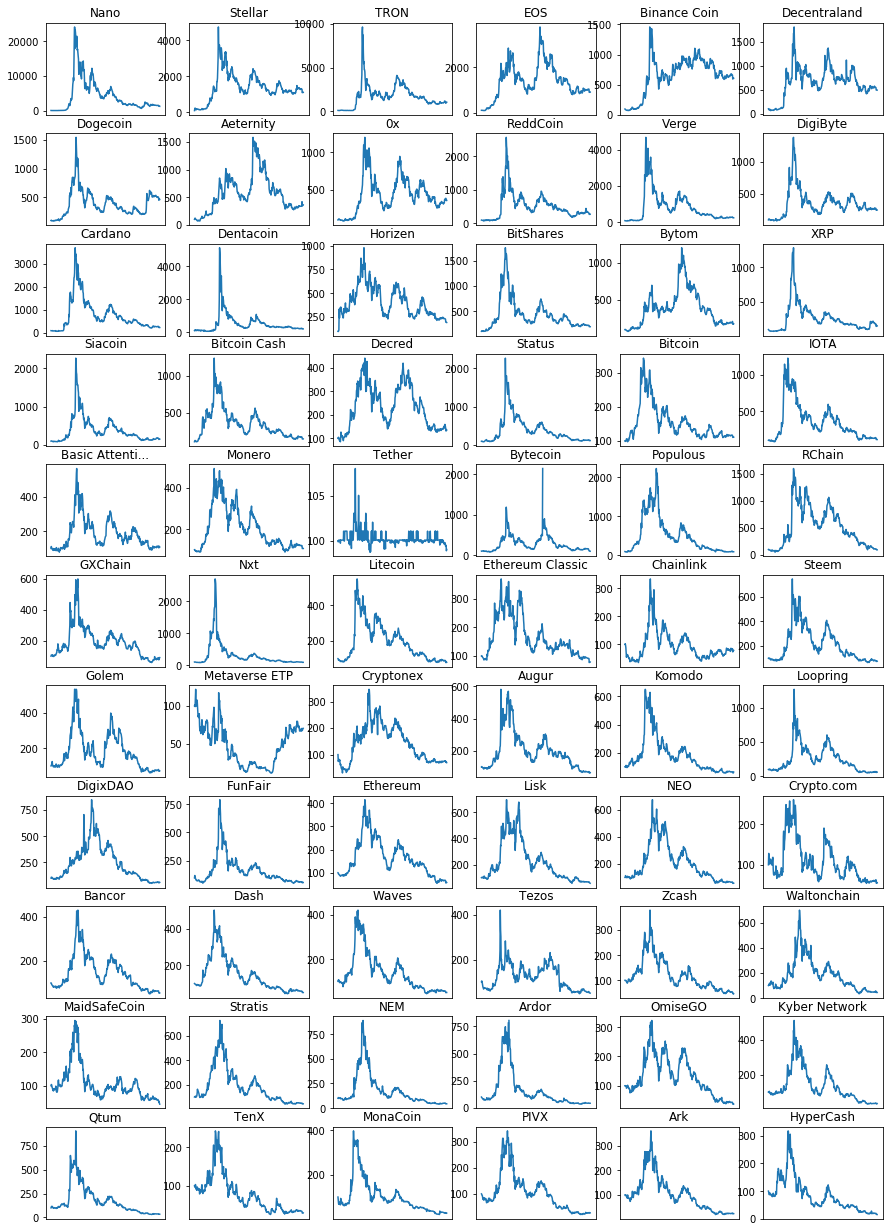

In [51]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,22))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index): #der enumerate-Funktion indexiert die Plots
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(11, 6, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())

Falls wir zusätzlich noch wollen, dass jeder Plot dieselbe y-Achse hat:

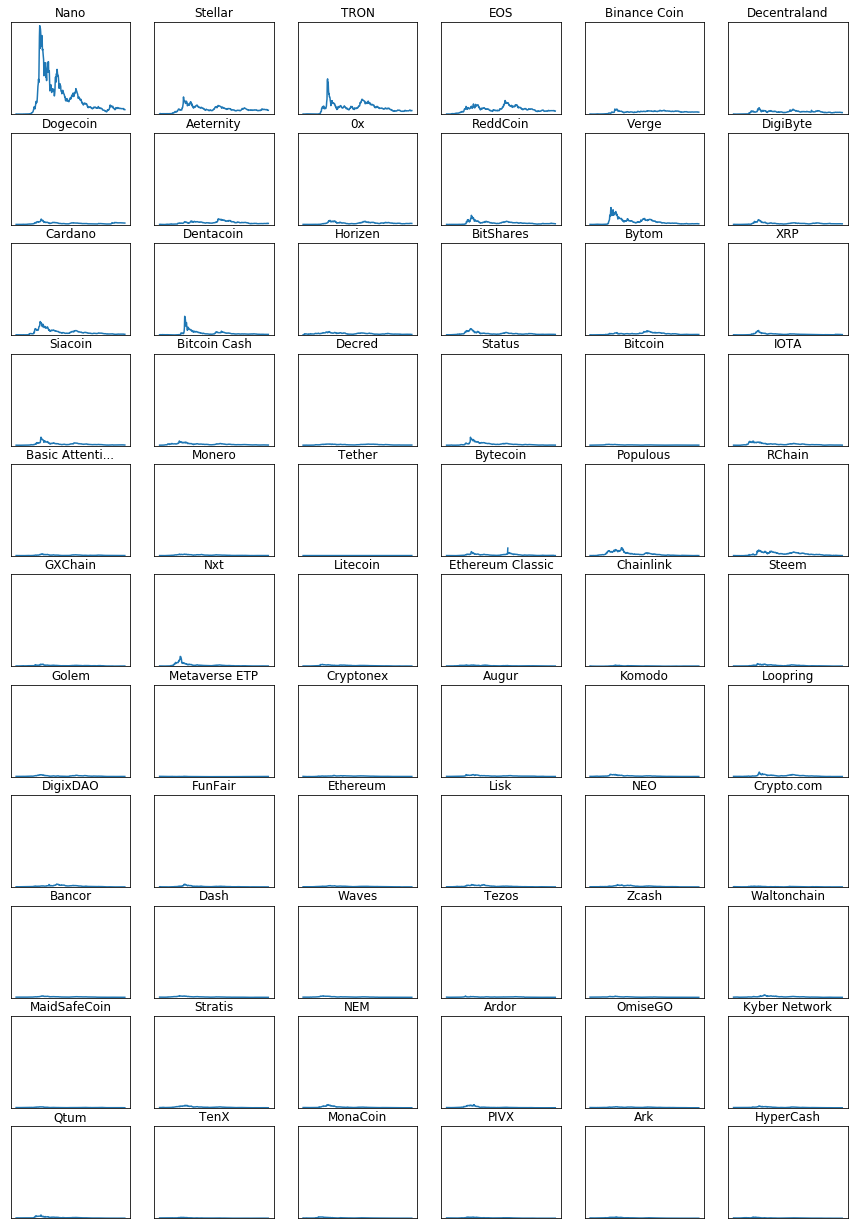

In [53]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,22))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(11, 6, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Hier setzen wir eine einheitliche y-Achse (und schalten sie aus)
    ax.set_ylim([0, 25000])
    ax.yaxis.set_major_locator(ticker.NullLocator())

### Aber es geht auch einfacher...

Ha! Nachdem wir nun alles Manuell zusammengebastelt haben, mit Matplotlib, hier die gute Nachricht:

*Wir können das mit wenigen Codezeilen auch direkt aus der Pandas-Plot()-Funktion haben :-)*

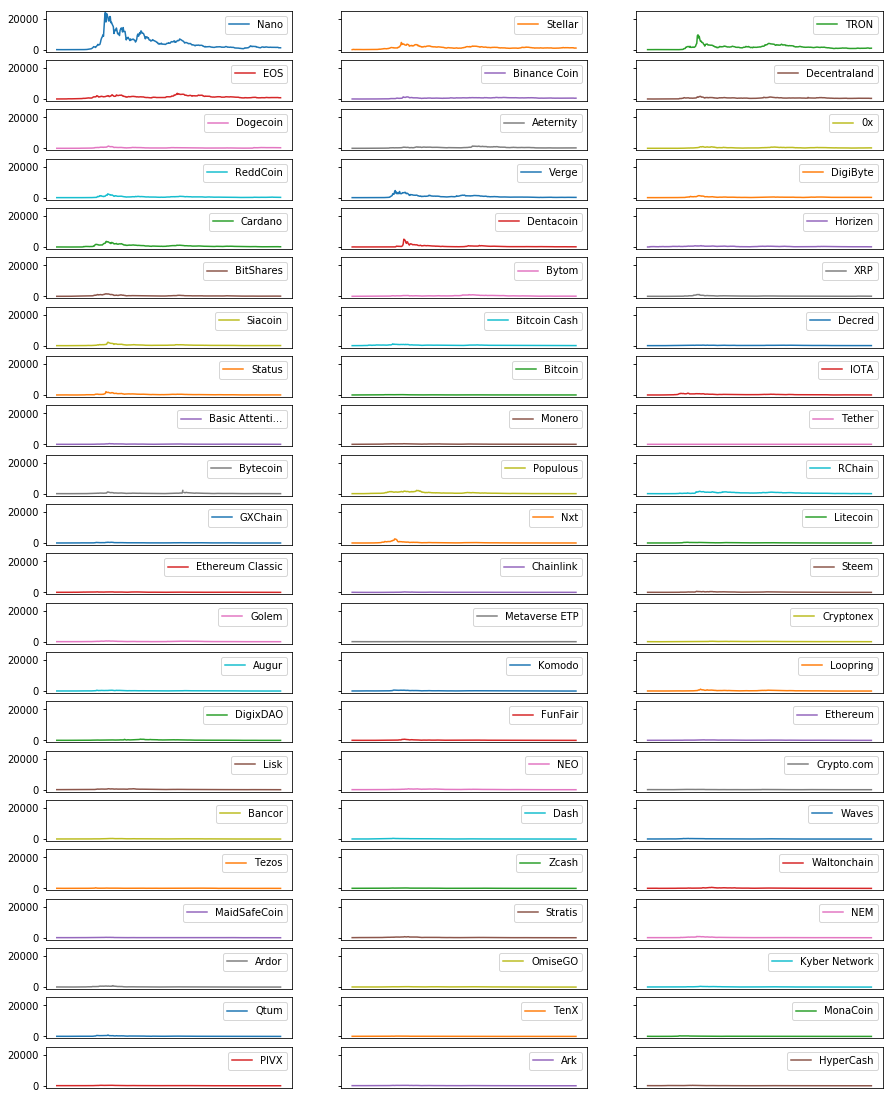

In [56]:
axes = df_pivoted_100[sortierte_waehrungen.index].plot(subplots=True,layout=(22, 3), sharey=True, figsize=(15,22))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())

# Übung

Hier schauen wir uns nicht mehr die Handelskurse, sondern die Handelsvolumen an! Also: Wie viel von den einzelnen Kryptowährungen an einem bestimmten Tag gekfauft und verkauft wurde (gemessen in USD).

Schauen Sie sich nochmals das Dataframe `df_all` an, das wir im Verlauf des Notebooks erstellt haben - es enthält alle Informationen, die wir brauchen, ist aber noch relativ unstrukturiert.

Welche Spalte interessiert uns? Müssen wir noch etwas daran machen?

### Daten arrangieren

Unternehmen Sie die nötigen Schritte, um mit der Spalte arbeiten zu können. Sie sollten am Ende eine Spalte haben, die nicht mehr als Object, sondern als Float formatiert ist.

Tipp: Speichern Sie alle Modifikationen in einer neuen Spalte ab, damit das Original unverändert bleibt.

Nun wollen wir die Daten umgliedern:
- Für jedes Datum wollen wir eine Zeile
- Für jede Kryptowährung eine Spalte
- Wir interessieren uns für die Handelsvolumen

Formatieren Sie die Werte in der Index-Spalte als Datetime-Objekte und sortieren Sie das Dataframe nach Datum.

### Analyse

Wir machen in dieser Sektion einige einfache Auswertungen und repetieren einige Befehle, u.a. aus dem Time Series Sheet.

**Top-10**: Welches waren, im Schnitt, die zehn meistgehandelten Währungen? Liste und Chart.

Welches waren die zehn Währungen, bei denen das Volumen in absoluten Zahlen am meisten geschwankt ist? (Standardabweichung)

Sieht so aus, als wären es dieselben zehn Währungen.

Können wir angeben, welche von ihnen relativ die grössten Schwankungen hatten, also im Vergleich zum Handelsvolumen?

**Bitcoin vs Ethereum**

Erstellen Sie einen Chart mit dem wöchentlichen Umsatztotal von Bitcoin und Ethereum!

In welchem der letzten 12 Monate wurde insgesamt am meisten mit Bitcoin gehandelt? Mit Ethereum?

Wie viel Bitcoin und Ethereum wird im Durchschnitt an den sieben Wochentagen gehandelt? Barchart.

**Small Multiples**: Hier erstellen wir einen Plot, ähnlich wie oben

Kreieren Sie zuerst eine Liste von Währungen:
- Alle Währungen, die am letzten Handelstag einen Eintrag haben
- Sortiert in absteigender Reihenfolge nach dem Handelsvolumen
- Wir wählen nur die zehn grössten aus

Und jetzt: Small Multiples plotten! Überlegen Sie sich:
- Wie viele Subplots braucht es, wie sollen sie angeordnet sein?
- Wie gross muss die Abbildung insgesamt sein?
- Was ist eine sinnvolle Einstellung für die Y-Achse?

(Sie können die Matplotlib-Funktionalität dafür nutzen oder direkt Pandas-plot()